
# Visualization Multi-Class Egg Status Detection (MONO dataset)

계란 상태 자동 탐지 데이터 셋 (반광)의 학습 결과를 가시화하기 위한 노트북입니다.


In [1]:
# Importing libraries
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob


import torch
import torchvision.transforms as T
import torchvision
from models import build_model

In [2]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

CLASSES = [
    'None',
    'Normal',
    'Blood Spot',
    'Crack',
    'Bleached',
    'Impurity',
    'Deformity',
    'Latent Crack',
    'N/A'
]

In [3]:
# Create arguments class for build DETR model
class Args:
    lr_backbone = 2e-4
    masks = None
    # Model parameters
    frozen_weights = None
    backbone = 'resnet50'
    dilation = False
    position_embedding = 'sine'
    enc_layers = 6
    dec_layers = 6
    dim_feedforward = 2048
    hidden_dim = 256
    dropout = 0.1
    nheads = 8
    num_queries = 100
    pre_norm = False
    aux_loss = False
    num_classes = 9
    set_cost_class=1
    set_cost_bbox=5
    set_cost_giou=2
    mask_loss_coef=1
    dice_loss_coef=1
    bbox_loss_coef=5
    giou_loss_coef=2
    eos_coef=0.1
    num_bbox_reg_classes = 2
    # Dataset parameters
    dataset_file = 'coco'
    coco_path = './MONO_10K'
    remove_difficult = False
    coco_panoptic_path = None
    # Device parameters
    device = 'cuda'
    seed = 42
    # Misc
    output_dir = ''
    resume = './outputs/best_Mono.pth' # Path to load weights model


args = Args()

In [4]:
# Preprocess image - Get list of images
def collect_all_images(dir_test):
    """
    Function to return a list of image paths.

    :param dir_test: Directory containing images or single image path.

    Returns:
        test_images: List containing all image paths.
    """
    test_images = []
    if os.path.isdir(dir_test):
        image_file_types = ['*.jpg', '*.jpeg', '*.png', '*.ppm']
        for file_type in image_file_types:
            test_images.extend(glob.glob(f"{dir_test}/{file_type}"))
    else:
        test_images.append(dir_test)
    return test_images   

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_min, y_min, w, h = x.unbind(1)
    b = [x_min - 0.5 * w, y_min - 0.5 * h, x_min + 0.5 * w, y_min + 0.5 * h]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [5]:
# Compute distance between two points (x1, y1) and (x2, y2)
def distance(x, y):
    return ((x[0] - y[0])**2 + (x[1] - y[1])**2)**0.5

# Put everything on detect function
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.8

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    #bboxes_scaled = bboxes_scaled.tolist()

    return probas[keep], bboxes_scaled

def Select_Bounding_Boxes(probas, bboxes_scaled):

    # Finding the center coordinates of the bounding box
    center_x = (bboxes_scaled[:, 0] + bboxes_scaled[:, 2]) / 2
    center_y = (bboxes_scaled[:, 1] + bboxes_scaled[:, 3]) / 2

    # Combine center_x and center_y to get the center coordinates
    center = torch.stack((center_x, center_y), dim=1)
    center = center.tolist()

    # Remove the center coordinates that are too close to each other
    dist = 0
    index_remove = []
    for i in range(len(center)):
        for j in range(i + 1, len(center)):
            dist = distance(center[i], center[j])
            if dist < 50:
                # Remove the center with the lower confidence
                if probas[i].max() > probas[j].max():
                    index_remove.append(j)
                else:
                    index_remove.append(i)


    bboxes_scaled = bboxes_scaled.tolist()
    probas = probas.tolist()

    # Delete bounding boxes having index in index_remove
    # Sort index_remove in descending order
    index_remove.sort(reverse=True)
    for i in index_remove:
        del bboxes_scaled[i]
        del probas[i]
    
    # Convert list to tensor
    probas = torch.tensor(probas)
    return probas, bboxes_scaled


def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    pil_img = plt.imread(pil_img)
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes, COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# DETR Inference Visualization

한 개의 MONO 이미지를 입력으로 한 DETR 탐지 결과 가시화

/home/yejyang/anaconda3/envs/kkokkobot/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/yejyang/anaconda3/envs/kkokkobot/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


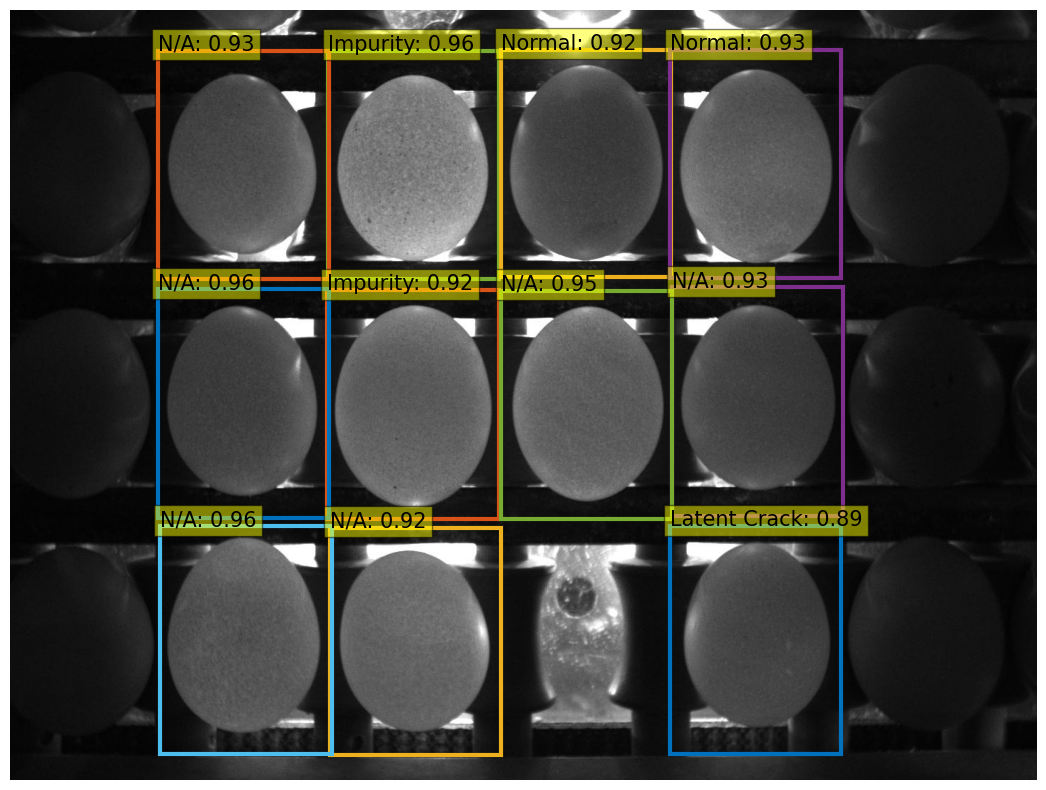

In [6]:
# Load model
model, criterion, postprocessors = build_model(args)
checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)

# Inference phase visualization
image = './MONO_Images_Demo/0505133001_0_06348.jpg'
img = Image.open(image)
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


scores, boxes = detect(img, model, transform)
scores_1, boxes_1 = Select_Bounding_Boxes(scores, boxes)
plot_results(image, scores_1, boxes_1)


여러 개의 반광 이미지를 입력으로 한 DETR 탐지 결과 가시화

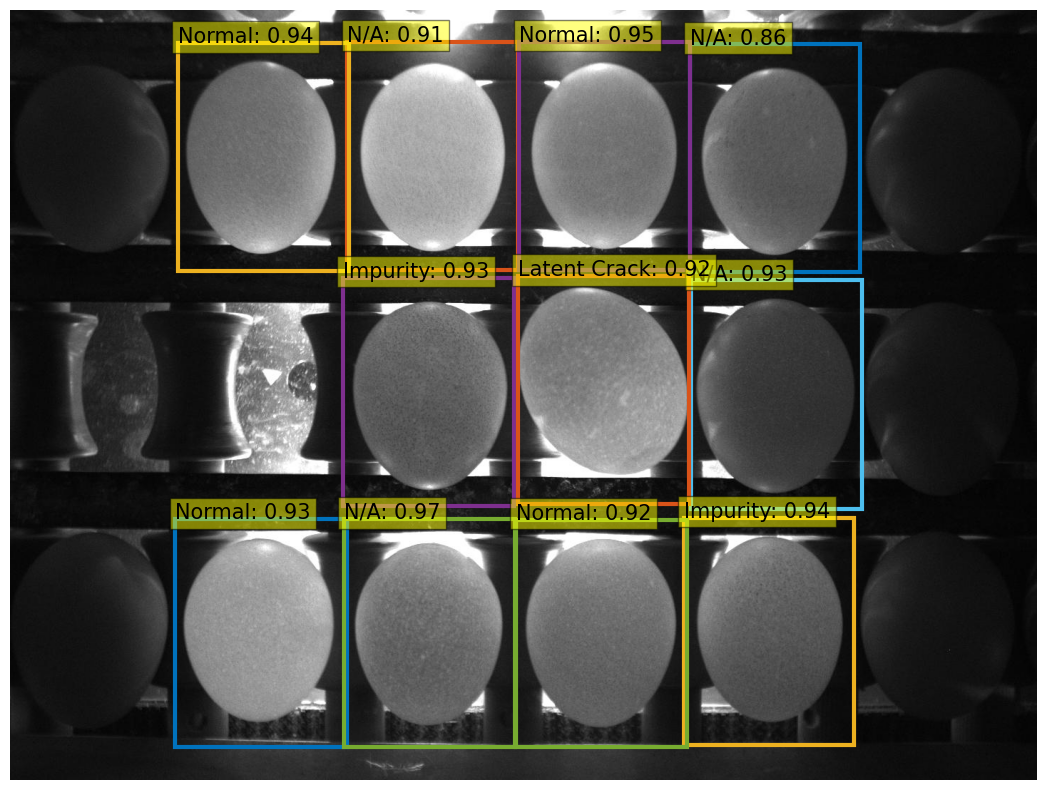

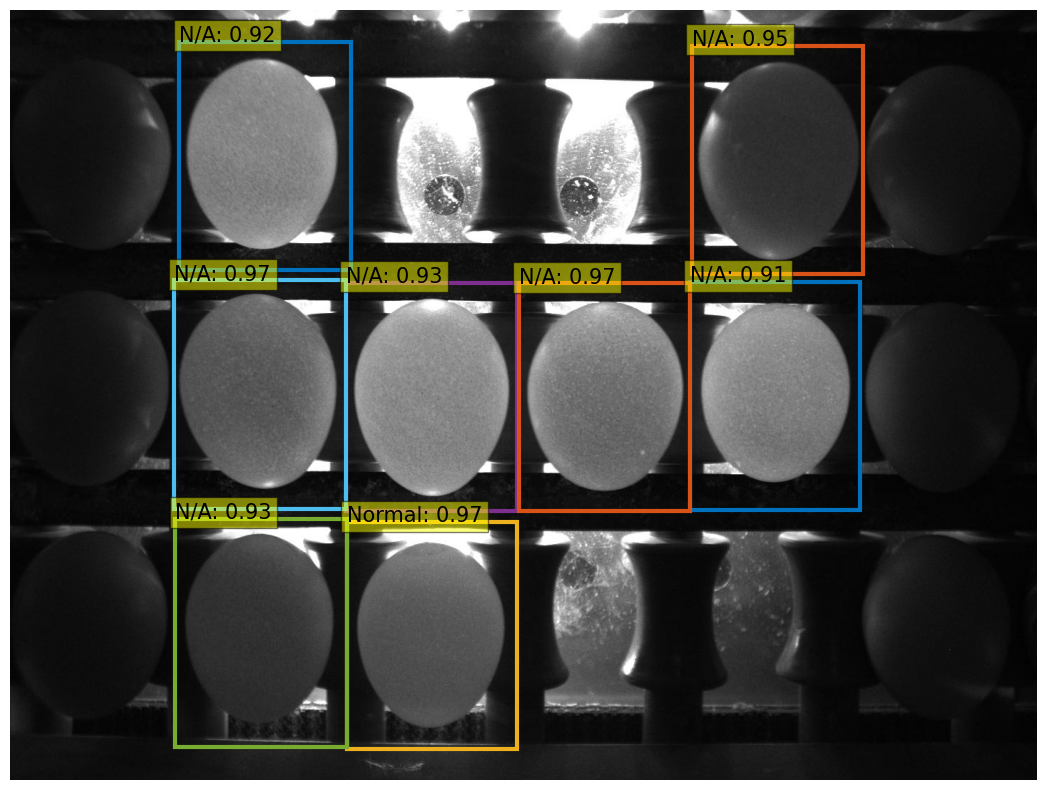

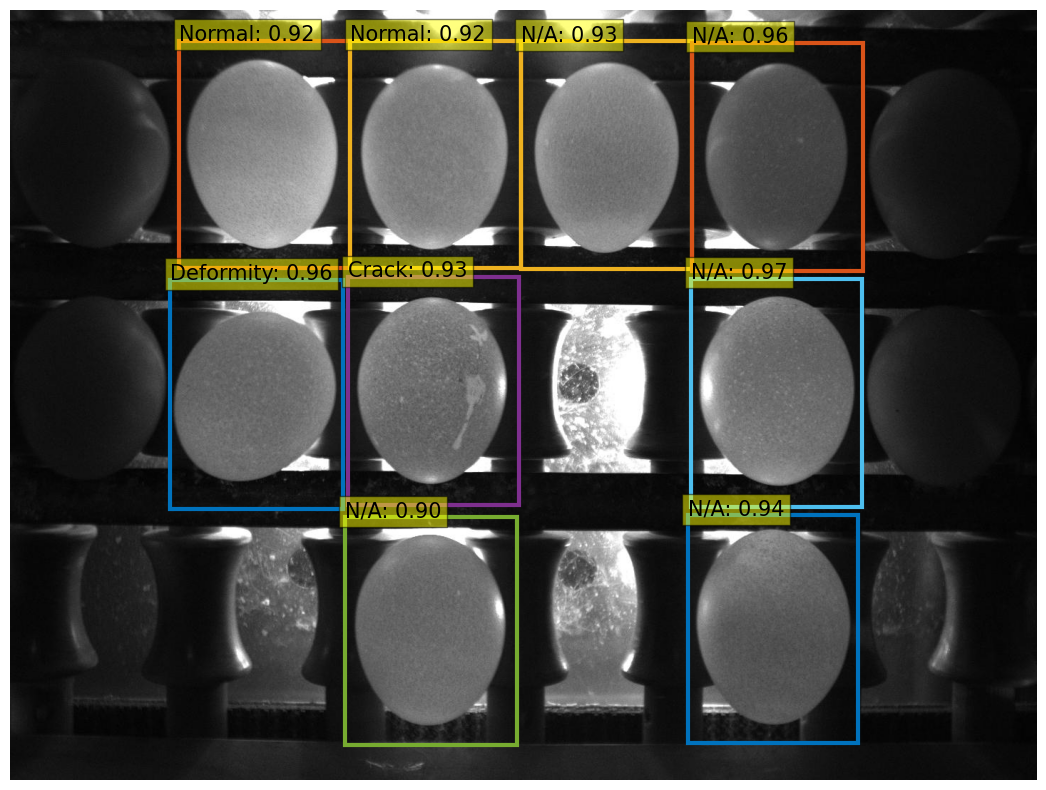

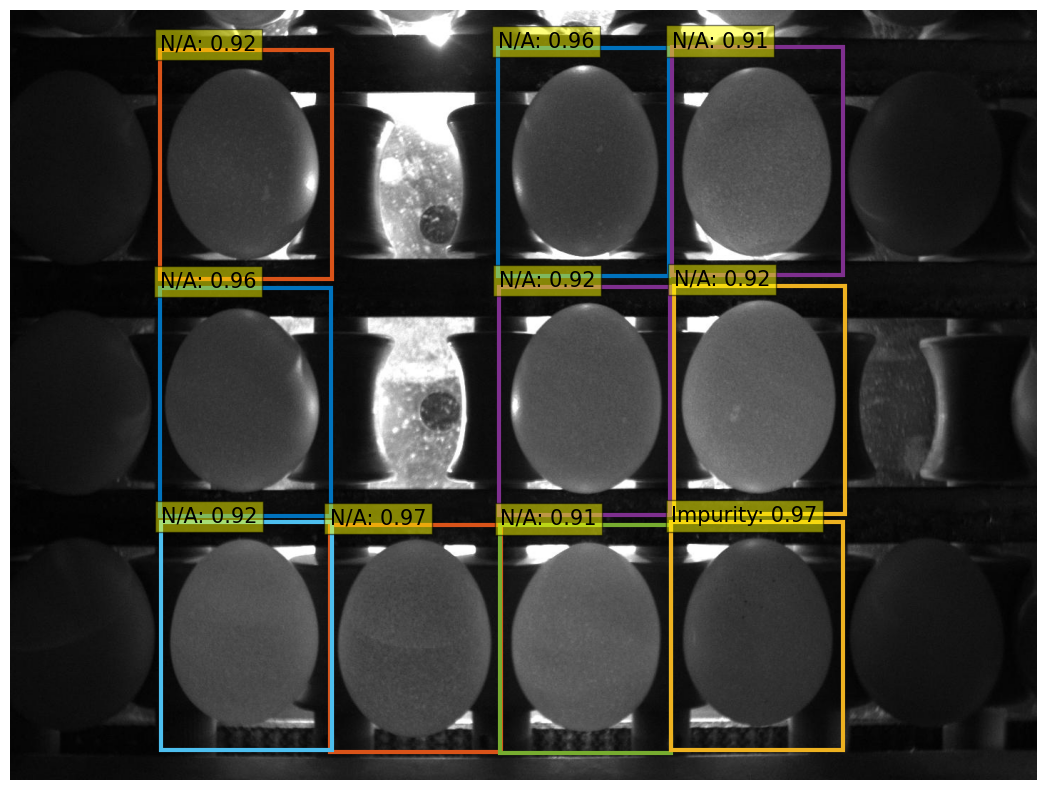

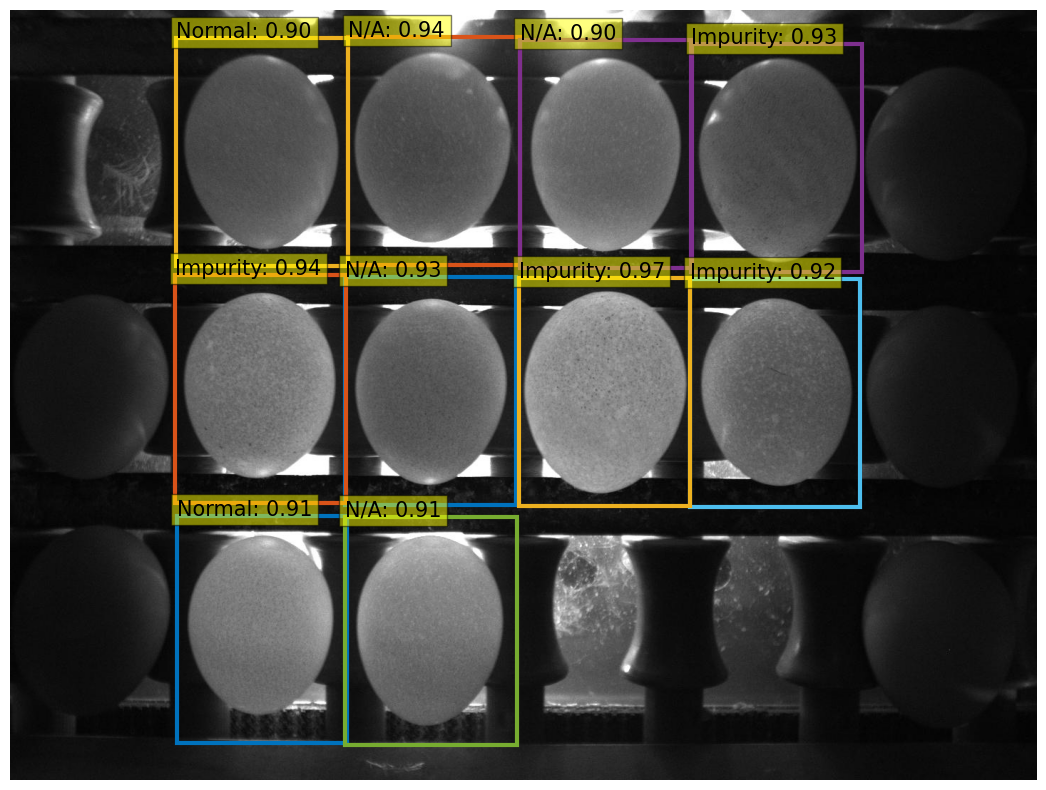

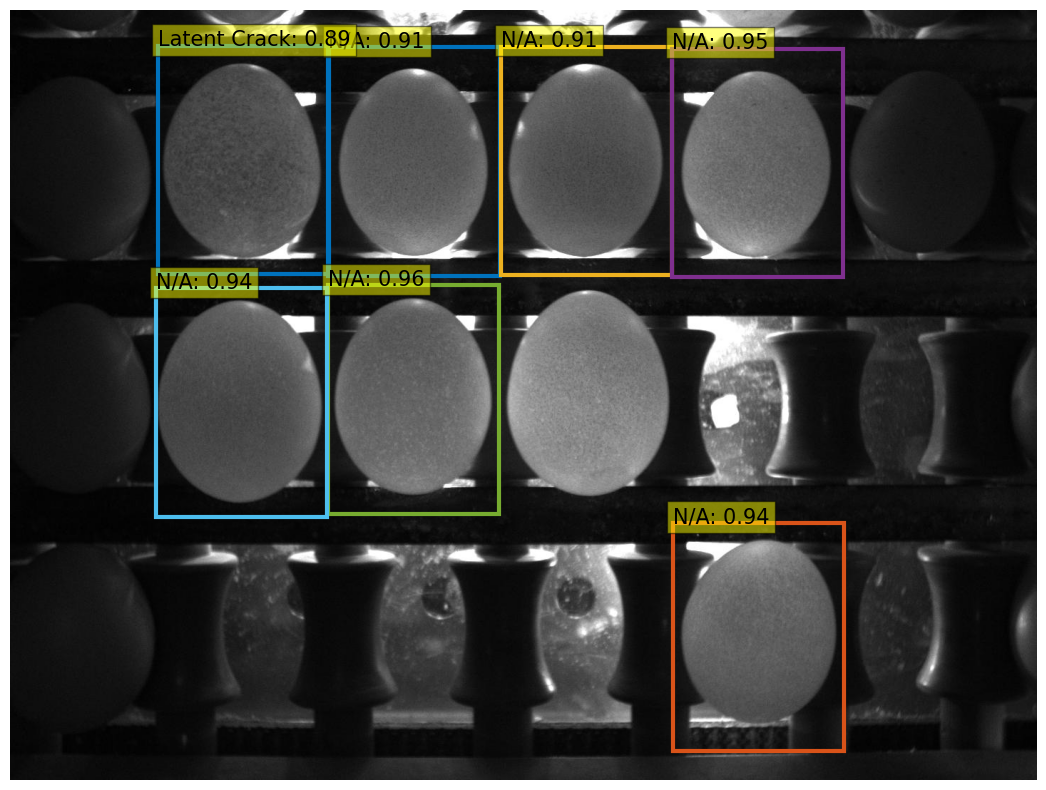

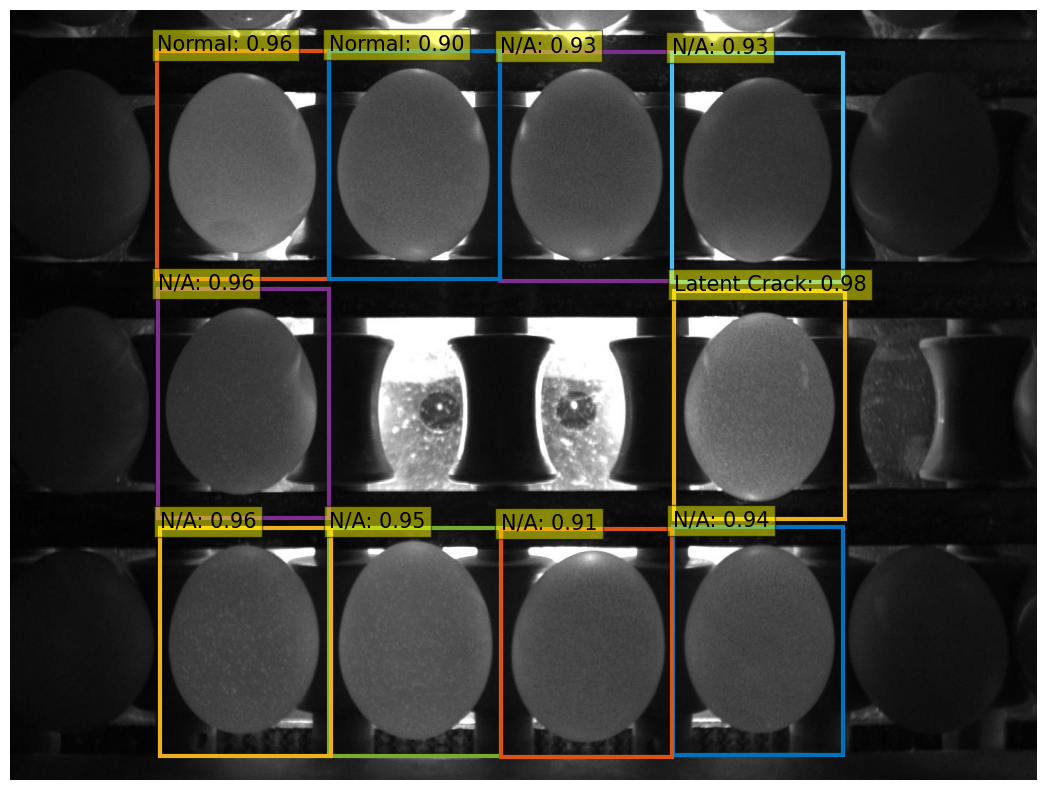

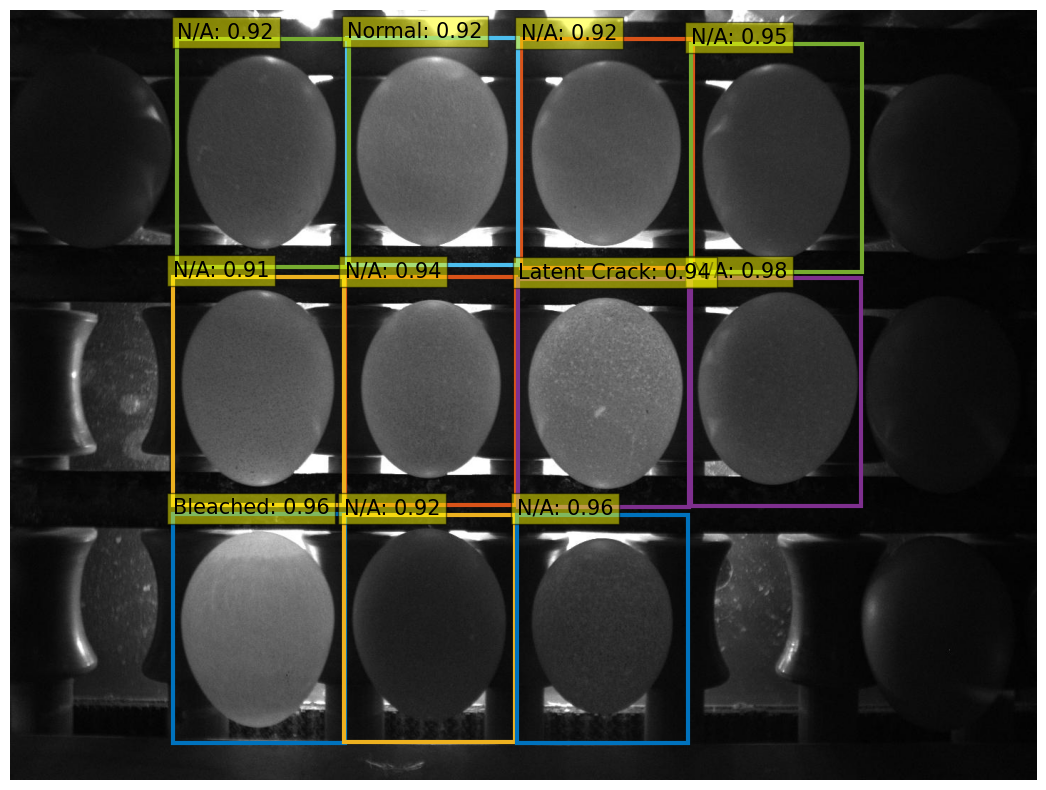

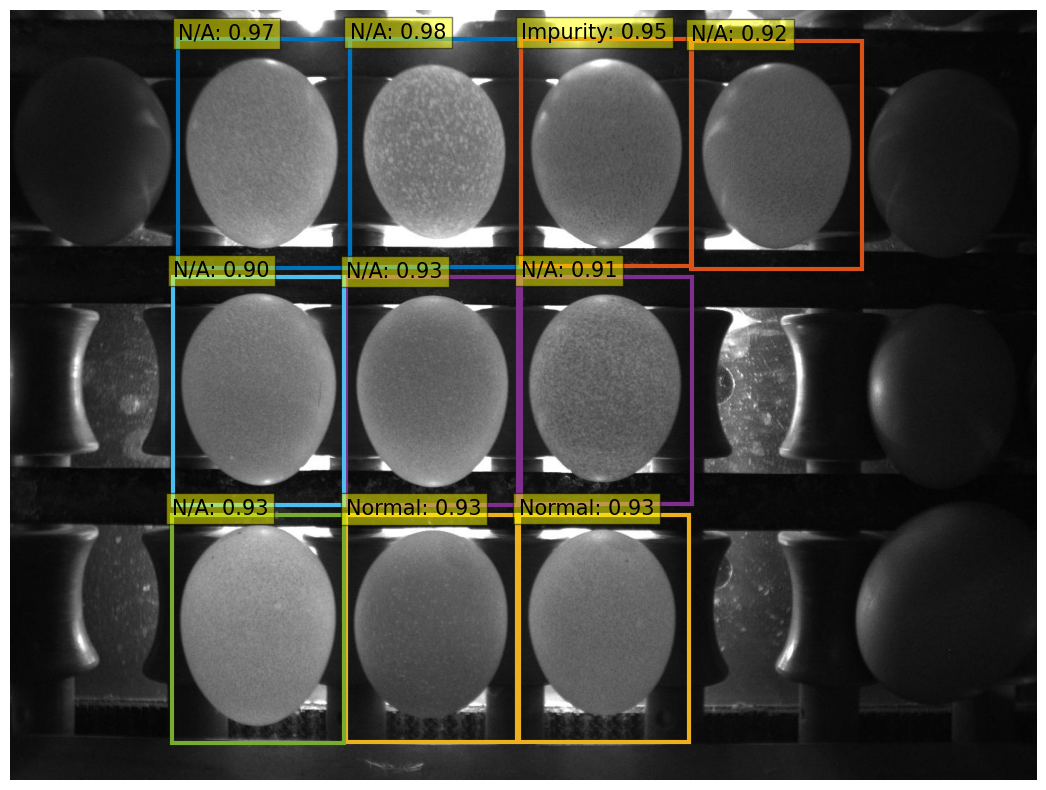

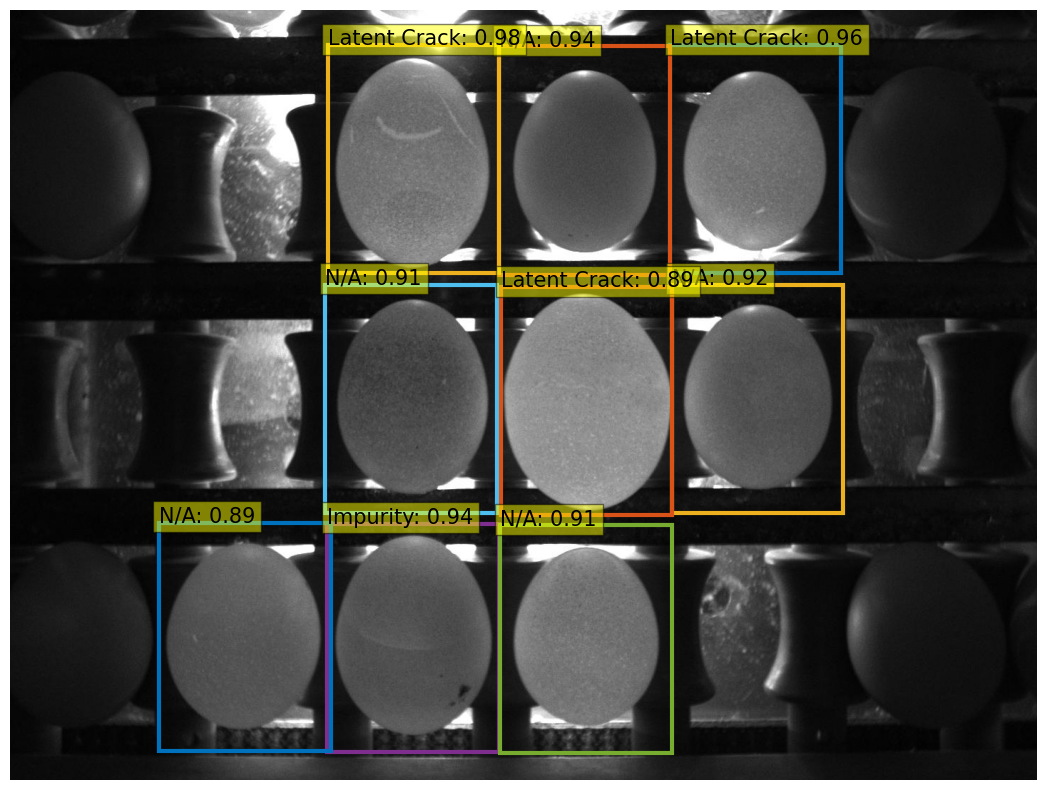

In [9]:
DIR_TEST = './MONO_Images_Demo/'
test_images = collect_all_images(DIR_TEST)

count = 0
number_of_visualize = 10

for image in test_images:
    if (count == number_of_visualize):
        break
    img = Image.open(image)

    scores, boxes = detect(img, model, transform)
    scores_1, boxes_1 = Select_Bounding_Boxes(scores, boxes)
    plot_results(image, scores_1, boxes_1)
    count += 1